# Batch discriminator

Goal: Neuronal network that can distinguish between batches of the large atac gene activity data set

In [97]:
#import numpy and keras modules
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2

#import Scanpy modules
import scanpy as sc
import anndata as ad

#import os and matplotlib
import os
import matplotlib 
import matplotlib.pyplot as plt

#import sklearn modules
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

# Set a random seed for reproducibility
random_seed = 42

## Load data

In [98]:
#set base path to load data: goes back one directory and then into the data
base_path = os.path.join('..', 'data', 'raw')

#Name of data set
dataset_name = 'large_atac_gene_activity'



# read dataset into an anndata object:  Category - Cells of the brain
inPath = os.path.join(base_path, f"{dataset_name}.h5ad")
adata = sc.read(inPath)

## Look at Data and Plot it

In [99]:
#Lets look at the data
X_numpy = adata.X.toarray()
print(X_numpy.shape) # array: each row corresponding to one cell, each collumn to one gene

#Metadata
adata.obs['batchname_all'] # 11 batches

(84813, 3580)


AAACGAAAGTAATCAG-1-0-0                                              10x Genomics
AAACGAACACGCTGTG-1-0-0                                              10x Genomics
AAACGAATCCTGGGAC-1-0-0                                              10x Genomics
AAACGAATCGGGAAAC-1-0-0                                              10x Genomics
AAACTCGAGAAAGCAG-1-0-0                                              10x Genomics
                                                            ...                 
TCTCGCGCTTGCCGTAGGCAATGAGTCCGGCTCTGA-1-1    Cusanovich et al. - Cerebellum_62216
TCTCGCGCTTGCCGTAGGGGTACGTTAATATAGCCT-1-1    Cusanovich et al. - Cerebellum_62216
TCTCGCGCTTGCCGTAGGTTGGTCCGTTTATAGCCT-1-1    Cusanovich et al. - Cerebellum_62216
TCTCGCGCTTGGTAAGGATCAATATCGAGGCTCTGA-1-1    Cusanovich et al. - Cerebellum_62216
TCTCGCGCTTGGTAAGGATTATGACCAATATAGCCT-1-1    Cusanovich et al. - Cerebellum_62216
Name: batchname_all, Length: 84813, dtype: category
Categories (11, object): ['10x Genomics', 'Cusanovich et 

In [100]:
X_numpy[0]

array([0.061027  , 0.22451097, 0.061027  , ..., 0.        , 0.        ,
       0.        ], dtype=float32)

In [101]:
#Metadata names to color graph later on
label_key = 'final_cell_label'
batch_key = 'batchname_all'

#Options for plotting
matplotlib.rc('ytick', labelsize=14)
matplotlib.rc('xtick', labelsize=14)
sc.set_figure_params(dpi_save=300)

# Dimensionality Reduction of Data
sc.pp.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=25)
sc.tl.umap(adata, random_state=42)


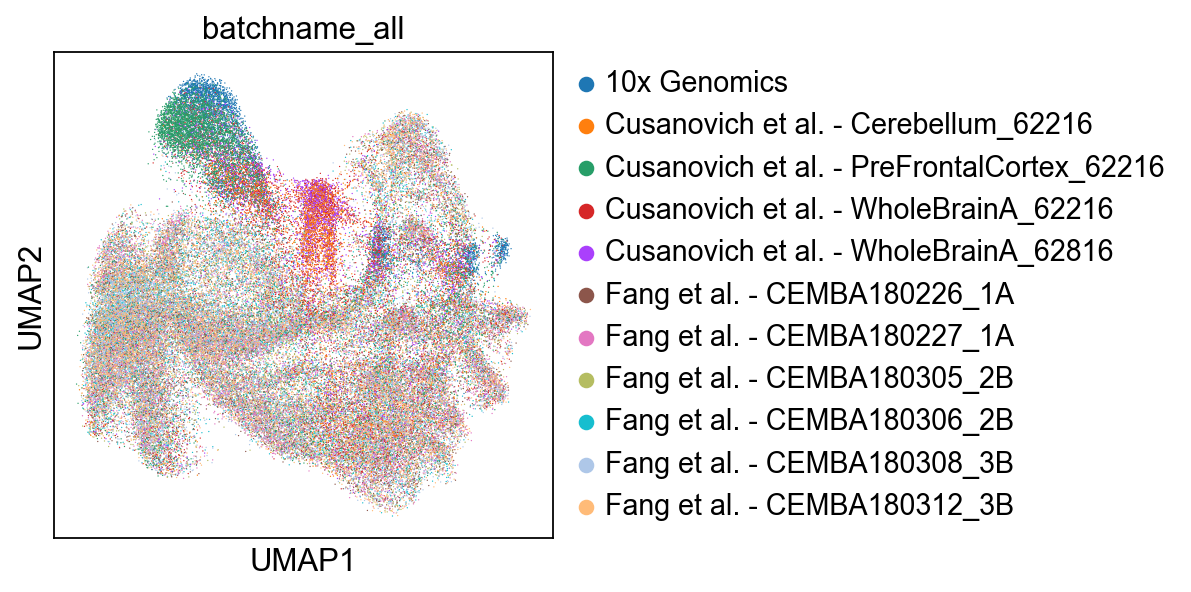

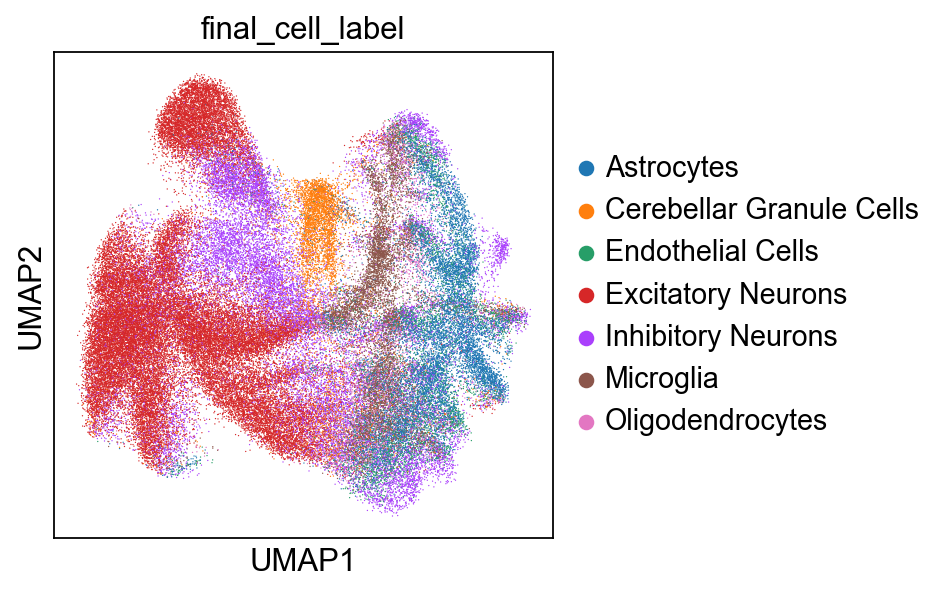

In [102]:
# --- Plot original data ---
sc.pl.umap(adata, palette=matplotlib.rcParams["axes.prop_cycle"],
           color=[batch_key], show=True, use_raw=False) #coloured by batch: batch effect present
sc.pl.umap(adata, palette=matplotlib.rcParams["axes.prop_cycle"],
           color=[label_key], show=True, use_raw=False) #coloured by cell type

## Batch discriminator
#### Input: Gen expression vector xi and cell label tl (hot-encoded)
#### Output: Probability distribution over 11 batches
#### Loss function: categorical cross-entropy (predicted probabilities vs. true batch labels)

In [108]:
#---Prepare Data---
#Encode the cell labels as One hot vector to use as additional information
encoder = OneHotEncoder(sparse_output=False)  # `sparse=False` returns a dense array
encoded_labels = encoder.fit_transform(adata.obs[['final_cell_label']])

# Concatenate gen expreesion matrix with oneHotLabels
INPUT = np.concatenate((X_numpy, encoded_labels), axis=1)
INPUT.shape[1]-X_numpy.shape[1] # 7 extra X values for the one-hot encoding

#One-hot encoded Batches
encoder = OneHotEncoder(sparse_output=False)  # `sparse=False` returns a dense array
OUTPUT = encoder.fit_transform(adata.obs[['batchname_all']])

#Perform a Train Test Split
INPUT_train, INPUT_test, OUTPUT_train, OUTPUT_test = train_test_split(INPUT, OUTPUT, test_size=0.2, random_state=random_seed)

#Output and Input size of NN
INPUT_size = INPUT[0].size
OUTPUT_size = OUTPUT[0].size



In [104]:
#---Build the model---
#Initilize the model
model = Sequential()
#Define Hyperparameters
OPTIMIZER = 'adam'                  #optimizer
LOSS = 'categorical_crossentropy'   # loss function
N_HIDDEN = 256                      # Number of nodes in hidden layers
ACTIVATION_FUNCTION = 'relu'        #activation function
L2_LAMBDA = 0.0075                   # Regularization strength

# First hidden layer with L2 regularization
model.add(Dense(N_HIDDEN, input_shape=(INPUT_size,), activation=ACTIVATION_FUNCTION, kernel_regularizer=l2(L2_LAMBDA)))

# Second hidden layer with L2 regularization
model.add(Dense(128, activation='relu', kernel_regularizer=l2(L2_LAMBDA)))

# Output layer (softmax for multi-class classification)
model.add(Dense(OUTPUT_size, activation='softmax'))

# Summary of the whole model
model.summary()

# model compilation
model.compile(loss='categorical_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])

c:\Users\lklei\anaconda3\envs\Tensorflow\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_22 (Dense)                │ (None, 256)            │       918,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 952,843 (3.63 MB)

 Trainable params: 952,843 (3.63 MB)

 Non-trainable params: 0 (0.00 B)

In [109]:
#---Train the model---
#Hyperparameters
BATCH_SIZE = 32
N_EPOCH = 40

#Fit the input to the output
history = model.fit(INPUT_train, OUTPUT_train, batch_size=BATCH_SIZE, epochs=N_EPOCH, verbose=2, validation_split=0.2)

#test the network
score = model.evaluate(INPUT_test, OUTPUT_test, verbose=2)
print("\nTest score/loss:", score[0])
print("Test accuracy:", score[1])


Epoch 1/40
1697/1697 - 6s - 3ms/step - accuracy: 0.3381 - loss: 1.8361 - val_accuracy: 0.3531 - val_loss: 1.7185
Epoch 2/40
1697/1697 - 5s - 3ms/step - accuracy: 0.4044 - loss: 1.6242 - val_accuracy: 0.4018 - val_loss: 1.6031
Epoch 3/40
1697/1697 - 5s - 3ms/step - accuracy: 0.4467 - loss: 1.5556 - val_accuracy: 0.4520 - val_loss: 1.5592
Epoch 4/40
1697/1697 - 5s - 3ms/step - accuracy: 0.4770 - loss: 1.5076 - val_accuracy: 0.4324 - val_loss: 1.6097
Epoch 5/40
1697/1697 - 5s - 3ms/step - accuracy: 0.4895 - loss: 1.4811 - val_accuracy: 0.4797 - val_loss: 1.4997
Epoch 6/40
1697/1697 - 5s - 3ms/step - accuracy: 0.4935 - loss: 1.4695 - val_accuracy: 0.4676 - val_loss: 1.5039
Epoch 7/40
1697/1697 - 5s - 3ms/step - accuracy: 0.4973 - loss: 1.4599 - val_accuracy: 0.4636 - val_loss: 1.5204
Epoch 8/40
1697/1697 - 5s - 3ms/step - accuracy: 0.4993 - loss: 1.4526 - val_accuracy: 0.4693 - val_loss: 1.4935
Epoch 9/40
1697/1697 - 5s - 3ms/step - accuracy: 0.4975 - loss: 1.4526 - val_accuracy: 0.4643 - 

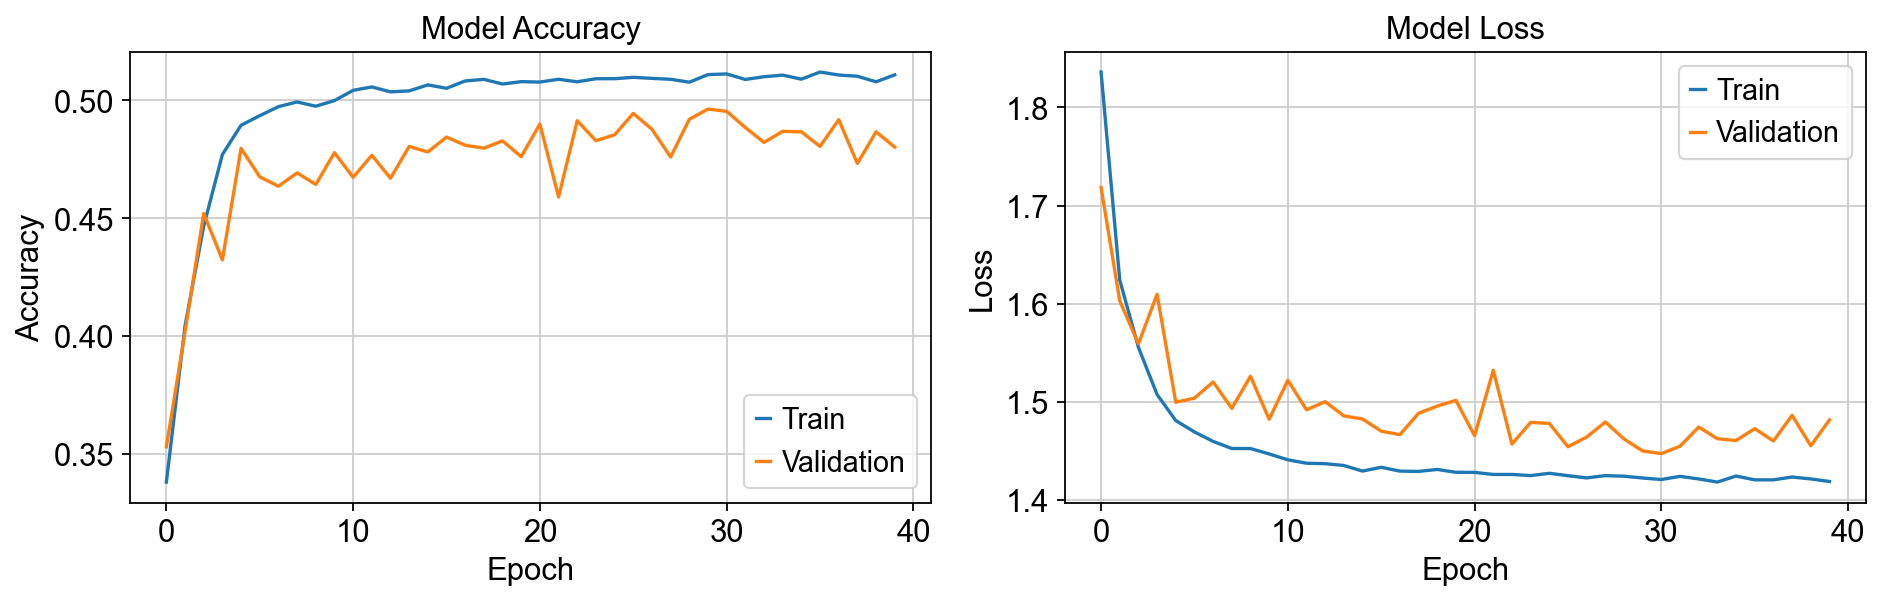

In [110]:
#--Visualisize Training---
# Plot training & validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()
#Plots show Accuracy improvment with training and loss decreasing only with Train and validation data: no overfitting
#But: Accuracy a bit low